##Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

##Change directory

In [ ]:
%cd /content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject

/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject


In [ ]:
%pwd

'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject'

##Download Dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RWP0ijumYGd10DQFn13D")
project = rf.workspace("burapha-university-koant").project("ivus-100-f6kgm")
version = project.version(1)
dataset = version.download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to IVUS-100-1 in tensorflow:: 100%|██████████| 108/108 [00:01<00:00, 80.87it/s]


##Read file

In [ ]:
train = pd.read_csv(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/train/_annotations.csv")
test = pd.read_csv(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/_annotations.csv")

In [ ]:
train.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
65,frame_01_0003_001_png.rf.f34656efbd854ec9de462...,384,384,Lumen,91,90,289,259
66,frame_01_0018_003_png.rf.f45dd6d83bdb0f31faa90...,384,384,Lumen,65,73,266,266
67,frame_01_0020_002_png.rf.c60dd77cc6a3f78aa24fc...,384,384,Lumen,82,92,262,272
68,frame_01_0007_001_png.rf.f380b7609c32de7587fd8...,384,384,Lumen,94,75,268,253
69,frame_01_0009_003_png.rf.fcd42336738778e35badc...,384,384,Lumen,95,64,273,248


In [ ]:
unique_imgs = train.filename.unique()
unique_imgs

array(['frame_01_0011_005_png.rf.118ded0456e633c1c5b5ef9f3f28a2ef.jpg',
       'frame_01_0002_005_png.rf.111ac9f64ff24ab86118b4f128babbda.jpg',
       'frame_01_0008_001_png.rf.169bd798158d131c5ad134f9c3eb2cd5.jpg',
       'frame_01_0016_003_png.rf.391e0ae668d6dedfb6a0529ab9b731a2.jpg',
       'frame_01_0001_005_png.rf.15d2645e2ffb10b07d1fb0ac74b41c57.jpg',
       'frame_01_0002_001_png.rf.3a2748071275f700552f46c19bf2acbd.jpg',
       'frame_01_0012_001_png.rf.22583b2bbc3b655a8268425a114b4921.jpg',
       'frame_01_0013_003_png.rf.2f091fd5e3753e8bc6fdc5ed048c31e4.jpg',
       'frame_01_0006_001_png.rf.22029b0ca0984b5f8707168a2b6c192c.jpg',
       'frame_01_0005_002_png.rf.2a05ac9d8d28f4f7887acef23434b3ce.jpg',
       'frame_01_0002_002_png.rf.61c0be3a569f73ef24be160f996b07c4.jpg',
       'frame_01_0010_005_png.rf.08af459287ef810c3d8f32ad4042833e.jpg',
       'frame_01_0007_005_png.rf.6518466d367ff72010338de13cfc6f06.jpg',
       'frame_01_0002_003_png.rf.36d4a79725b17b805e310b4235315de

##Prepocessing

In [ ]:
# class สำหรับแก้ไข training Dataset
import torch.utils
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.filename == image_name].values[:, 4:].astype("float")
        img = Image.open(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/train/"+image_name)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return T.ToTensor()(img) , target

In [ ]:
# สร้าง training index ของรูป
train_inds = [i for i in range(70)]

In [ ]:
print(type(train_inds))
print(train_inds)

<class 'list'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


In [ ]:
def custom_collate(data):
    return data

In [ ]:
# แก้ Structure ของ training ให้เป็น DataLoader
train_dl = torch.utils.data.DataLoader(CustDat(train, unique_imgs, train_inds),
                                       batch_size = 16,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False
                                       )

In [ ]:
# Download Faster R-CNN model สำหรับรูปจาก pytorch
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#Use GPU for run the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# Optimizer model && Hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

In [ ]:
# Clear GPU memory **option**
import torch
torch.cuda.empty_cache()

##Training Model

In [ ]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)

2.999097500494542
2.102051242145739
1.6458846576325825
1.3117510715077225
1.2097024945449089
1.1273346711110563
1.0331539649011663
1.0001309185635883
0.9665094526765274
0.8824854829799872


In [ ]:
print(test.shape)

(10, 8)


In [ ]:
# class สำหรับแก้ไข testing Dataset
import torch.utils

class CustDat_test(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.filename == image_name].values[:, 4:].astype("float")
        img = Image.open(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/"+image_name)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return T.ToTensor()(img) , target

In [ ]:
unique_imgs_test = test.filename.unique()
unique_imgs_test

array(['frame_01_0017_002_png.rf.22f2e622b024dfb43dea54c50a0b128a.jpg',
       'frame_01_0005_005_png.rf.79174776f41ba3eea890a85e4f284cd1.jpg',
       'frame_01_0009_002_png.rf.e85223f58f24d4309124c597ef218a0e.jpg',
       'frame_01_0012_002_png.rf.5b6083e6192c1858973ac6ffa66d1d62.jpg',
       'frame_01_0001_004_png.rf.2688adeaf3c8afae3904d39e92a08426.jpg',
       'frame_01_0001_003_png.rf.075637138556500b9fb8bcbd5aad74f6.jpg',
       'frame_01_0001_001_png.rf.8eb7d7b265fb492a66525abd86087607.jpg',
       'frame_01_0020_003_png.rf.167c1386713db04732c5afaa02969800.jpg',
       'frame_01_0014_003_png.rf.da63485cdbadd13e21f7c9dc35a6d816.jpg',
       'frame_01_0007_003_png.rf.ff834c25207f362872e59b9abee19925.jpg'],
      dtype=object)

In [ ]:
test_inds = [i for i in range(10)]
print(test_inds)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# แก้ Structure ของ testing ให้เป็น DataLoader
test_dl = torch.utils.data.DataLoader(CustDat_test(test, unique_imgs_test, test_inds),
                                       batch_size = 8,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False
                                       )

##Evaluation model

In [ ]:
model.eval()
data = iter(test_dl).__next__()

In [ ]:
# select a image
img = data[2][0]
boxes = data[0][1]["boxes"]
labels = data[0][1]["label"]

In [ ]:
# model detection
output = model([img.to(device)])

In [ ]:
output

[{'boxes': tensor([[101.0271,  57.4246, 294.8426, 268.2424],
          [129.7106,  85.0976, 261.3549, 237.7157],
          [ 37.2338,  71.5469, 342.5963, 369.5828],
          [ 93.0223, 105.4038, 353.2232, 229.6098],
          [ 75.4829,  40.6867, 209.6595, 266.3072],
          [161.1097,  22.9267, 343.8934, 301.6212],
          [105.7275,  41.5431, 295.2768, 172.3206],
          [ 17.2123,  64.9163, 237.1392, 298.7352],
          [ 58.4817, 144.5167, 304.9276, 253.2975]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9320, 0.6315, 0.4886, 0.3433, 0.2517, 0.1162, 0.1047, 0.0920, 0.0633],
         device='cuda:0', grad_fn=<IndexBackward0>)}]

In [ ]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]

In [ ]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [ ]:
out_bbox.shape, keep.shape

(torch.Size([9, 4]), torch.Size([3]))

In [ ]:
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')

##Visualization

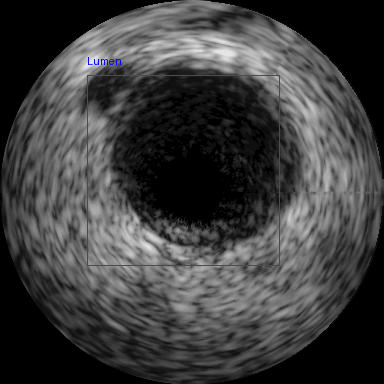

In [ ]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box), fill = None, outline = 'red')
    text_position = (box[0], box[1] - 20)
    draw.text(text_position, 'Lumen', fill='blue')
vsample

##Export model

In [ ]:
torch.save(model.state_dict(), "Faster_R-CNN.pt")

In [ ]:
import torch
import torchvision.models as models

# สร้างโมเดลใหม่โดยใช้สถาปัตยกรรมเดิมที่คุณเคยใช้ (เช่น Faster R-CNN)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 คลาส + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# โหลด weights เข้าไปในโมเดล
model_path = '/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/Faster_R-CNN.pt'  # เปลี่ยนเป็น path ของไฟล์โมเดล
model.load_state_dict(torch.load(model_path))

# ตั้งค่าโมเดลให้เป็นโหมด eval
model.eval()


<ipython-input-154-b124d61897b9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
from google.colab import files

model_path = '/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/Faster_R-CNN.pt'
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

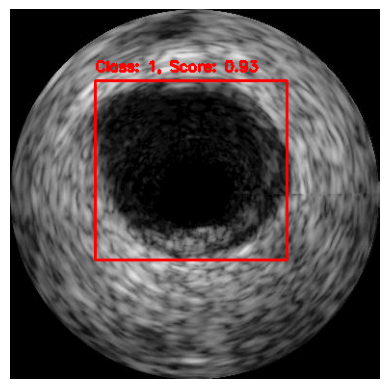

In [ ]:
import torch
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt

# # โหลดโมเดล Faster R-CNN
# model_path = '/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/Faster_R-CNN.pt'  # เปลี่ยนเป็น path ของไฟล์โมเดล
# model = torch.load(model_path)
model.eval()  # ตั้งค่าโมเดลให้เป็นโหมด eval

# ฟังก์ชันสำหรับการเตรียมรูปภาพ
def transform_image(image):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((384, 384)),  # ปรับขนาดให้เข้ากับโมเดล
        T.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # เพิ่มมิติ batch

# อ่านรูปภาพ
img_path = '/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/valid/frame_01_0004_002_png.rf.057ec23990bb4de9699086a7dec4ec88.jpg'  # เปลี่ยนเป็น path ของรูปภาพที่ต้องการตรวจจับ
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # เปลี่ยนสีจาก BGR เป็น RGB

# เตรียมรูปภาพ
input_tensor = transform_image(image_rgb)

# ทำการตรวจจับวัตถุ
with torch.no_grad():
    predictions = model(input_tensor)

# แสดงผลลัพธ์
boxes = predictions[0]['boxes'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()

# วาด bounding boxes บนรูปภาพ
for box, score, label in zip(boxes, scores, labels):
    if score > 0.6:  # กำหนด threshold สำหรับการแสดง bounding box
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # วาดกรอบ
        cv2.putText(image, f'Class: {label}, Score: {score:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# แสดงผลลัพธ์
plt.imshow(image)
plt.axis('off')  # ปิดแกน
plt.show()
